# Исследование о доходе с альтернативной версией сайта

Сайт запустил A/B-тест с целью увеличения дохода. Файл excel содержит исходные данные о результатах эксперимента (user_id), типе выборки (variant_name) и доходе, который принес пользователь (revenue).
Задача состоит в том, чтобы проанализировать результаты эксперимента и написать свои рекомендации.

## Содержание 

1. Познакомимся с датасетом и проанализируем базовые показатели
    - Структура данных
    - Баланс классов
    - Описательная статистика
2. Оценка размера дохода, от людей сделавших покупку. (удалить нулевые значения)
    - Очистка от нулевых значений
    - График пользователей по размеру прибыли
    - Попытка привидения к нормальному распределению
    - Манна Уитни тест
3. Оценка вовлечённости людей (не удалять нулевые значения)
    - Сравнение конверсии и оценка статистической значимости
    - Анализ времени до совершения транзакций
4. Итог

## 1. Познакомимся с датасетом и проанализируем базовые показатели

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

#### Структура данных

In [122]:
data = pd.read_csv('AB_Test_Results.csv', index_col='USER_ID')
data.head()

,VARIANT_NAME,REVENUE
USER_ID,,
737,variant,0.0
2423,control,0.0
9411,control,0.0
7311,control,0.0
6174,variant,0.0


#### Баланс классов

VARIANT_NAME
variant    5016
control    4984
Name: count, dtype: int64

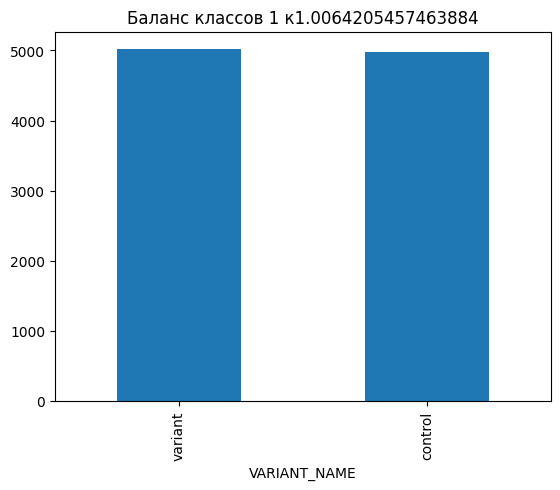

In [123]:
class_balance = data['VARIANT_NAME'].value_counts()
class_balance.plot(kind='bar', title=f'Баланс классов 1 к{class_balance["variant"] / class_balance["control"]}')
class_balance

Отличный баланс классов. Равные условия для анализа, минимизируется вероятность искажений, что позволяет обойтись без дополнительных методов коррекции выборки.

#### Описательная статистика

In [124]:
data.describe()

,REVENUE
count,10000.000000
mean,0.099447
std,2.318529
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,196.010000


По описанию Q1, Q2, Q3, видно очень много нулевых значений

In [125]:
data[data['REVENUE'] > 0]['VARIANT_NAME'].value_counts()

VARIANT_NAME
control    80
variant    72
Name: count, dtype: int64

Из 10к пользователей совершили покупку 152 человека. Здесь два пути, зависящие от нашей цели анализа.

## 2. Оценка размера дохода, от людей сделавших покупку. (удалить нулевые значения)
Если цель теста - узнать увеличился доход, от альтернативной версии сайта.
То можно удалить нулевые значения, и использовать только клиентов сделавших покупку.

#### Очистка от нулевых значений

In [126]:
data_no_zero = data[data['REVENUE'] > 0]
data_no_zero

,VARIANT_NAME,REVENUE
USER_ID,,
2529,variant,2.15
6429,control,3.25
3331,variant,4.27
8110,variant,1.75
8607,control,2.99
...,...,...
9928,variant,1.25
6468,control,2.93
5205,control,14.17


#### График пользователей по размеру прибыли

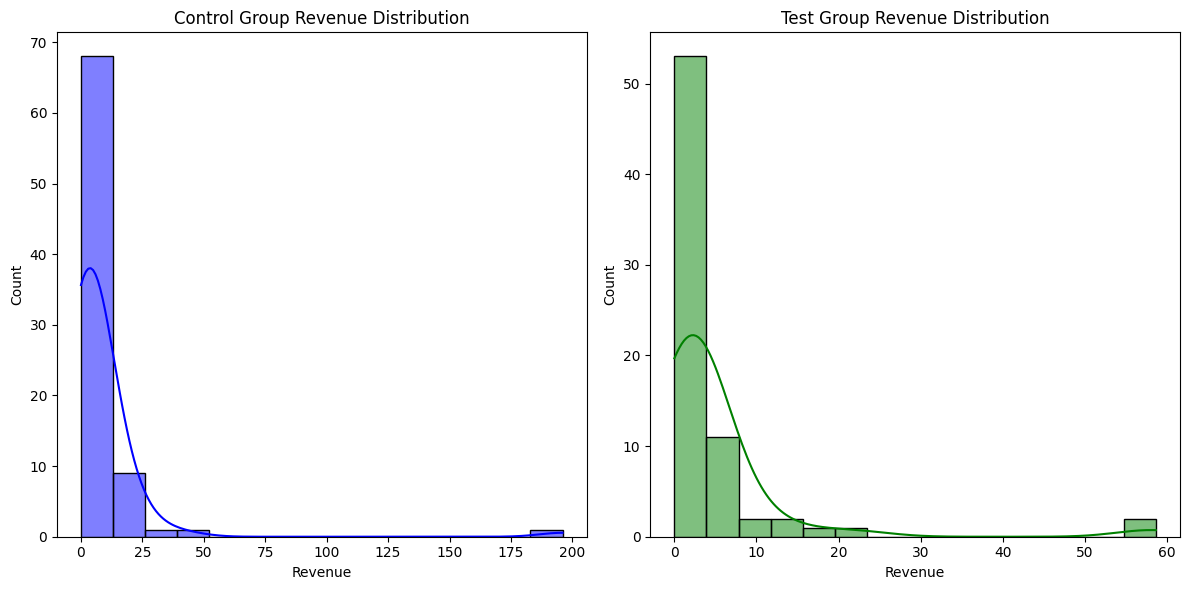

Shapiro-Wilka (Control Group): W-statistic=0.2808055877685547, p-value=6.5033072107817044e-18
Shapiro-Wilka (Test Group): W-statistic=0.4170522093772888, p-value=2.1140220769002042e-15


In [127]:
control_group = data_no_zero[data_no_zero['VARIANT_NAME'] == 'control']['REVENUE']
test_group = data_no_zero[data_no_zero['VARIANT_NAME'] == 'variant']['REVENUE']

plt.figure(figsize=(12, 6))

# Гистограмма для контрольной группы
plt.subplot(1, 2, 1)
sns.histplot(control_group, bins=15, kde=True, color='blue')
plt.title('Control Group Revenue Distribution')
plt.xlabel('Revenue')

# Гистограмма для тестовой группы
plt.subplot(1, 2, 2)
sns.histplot(test_group, bins=15, kde=True, color='green')
plt.title('Test Group Revenue Distribution')
plt.xlabel('Revenue')

plt.tight_layout()
plt.show()

# Тест Шапиро-Уилка для контрольной группы
shapiro_control = stats.shapiro(control_group)
print(f"Shapiro-Wilka (Control Group): W-statistic={shapiro_control.statistic}, p-value={shapiro_control.pvalue}")

# Тест Шапиро-Уилка для тестовой группы
shapiro_test = stats.shapiro(test_group)
print(f"Shapiro-Wilka (Test Group): W-statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")

Видно из графиков и подтвержденно с помощью текстов Шапиро-Уилка, что данные не распределены нормально.

#### Попытка привидения к нормальному распределению

Попробуем привести к нормальному виду для:
1. Использование статистических тестов с условием о нормальном распределении
2. Устойчивости к выбросам
3. Облегчения сравнения и интерпетируемости

Почему box-cox
1. Гибкость
2. Устойчивость к выбросам

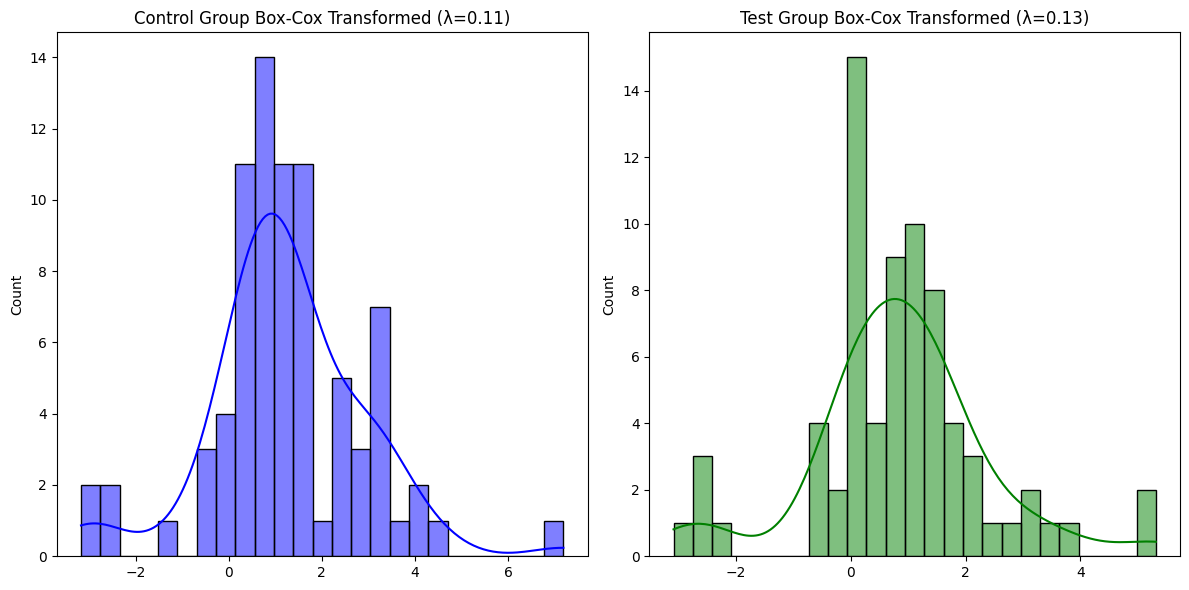

In [128]:
from scipy.stats import boxcox
# Применяем преобразование Бокса-Кокса
control_boxcox, lambda_control = boxcox(data_no_zero[data_no_zero['VARIANT_NAME'] == 'control']['REVENUE'])
test_boxcox, lambda_test = boxcox(data_no_zero[data_no_zero['VARIANT_NAME'] == 'variant']['REVENUE'])

plt.figure(figsize=(12, 6))

# Гистограмма для контрольной группы (Box-Cox)
plt.subplot(1, 2, 1)
sns.histplot(control_boxcox, bins=25, kde=True, color='blue')
plt.title(f'Control Group Box-Cox Transformed (λ={lambda_control:.2f})')

# Гистограмма для тестовой группы (Box-Cox)
plt.subplot(1, 2, 2)
sns.histplot(test_boxcox, bins=25, kde=True, color='green')
plt.title(f'Test Group Box-Cox Transformed (λ={lambda_test:.2f})')

plt.tight_layout()
plt.show()


In [129]:
from scipy.stats import shapiro

# Проверка нормальности распределения для контрольной группы после Бокса-Кокса
shapiro_control_boxcox = shapiro(control_boxcox)

# Проверка нормальности распределения для тестовой группы после Бокса-Кокса
shapiro_test_boxcox = shapiro(test_boxcox)

# Вывод результатов
print(f"Shapiro-Wilk Test (Control Group): W-statistic={shapiro_control_boxcox.statistic}, p-value={shapiro_control_boxcox.pvalue}")
print(f"Shapiro-Wilk Test (Test Group): W-statistic={shapiro_test_boxcox.statistic}, p-value={shapiro_test_boxcox.pvalue}")

Shapiro-Wilk Test (Control Group): W-statistic=0.9464906454086304, p-value=0.00218210625462234
Shapiro-Wilk Test (Test Group): W-statistic=0.9314526319503784, p-value=0.0007223141728900373


Не получаем нормальное распределение. Попробуем тогда критерий Манна уитни, чтобы определить, изменилась ли медиана доходов статистически значимо

#### Манна Уитни 

Нулевая гипотеза ($H_0$)
- Нет статистически значимого различия между контрольной и тестовой группами по среднему доходу от пользователя

Альтернативная гипотеза ($H_1$)
- Существует статистически значимое различие между контрольной и тестовой группами по среднему доходу от пользователя

In [130]:
from scipy.stats import mannwhitneyu

# Получаем доходы для каждой группы
control_revenue = data_no_zero[data_no_zero['VARIANT_NAME'] == 'control']['REVENUE']
test_revenue = data_no_zero[data_no_zero['VARIANT_NAME'] == 'variant']['REVENUE']

# Выполняем тест Манна-Уитни
u_statistic, p_value = mannwhitneyu(control_revenue, test_revenue, alternative='two-sided')
print(f"Mann-Whitney: U-statistic={u_statistic}, p-value={p_value}")

Mann-Whitney: U-statistic=3356.0, p-value=0.07924299810603061


С учетом стандартного уровня значимости p-value = 5%, мы не можем отвергнуть нулевую гипотезу, что указывает на отсутствие статистически значимых различий между группами. Таким образом, результаты тестирования подтверждают, что изменения не оказали заметного влияния на поведение пользователей.

## 3. Оценка вовлечённости людей (не удалять нулевые значения)
Если цель теста - узнать повысилась количество и уверености покупок от людей.

#### Сравнение конверсии и оценка статистической значимости

Нулевая гипотеза ($H_0$)
- Нет статистически значимого различия в конверсии между контрольной группой и тестовой группой

Альтернативная гипотеза ($H_1$)
- Существует статистически значимое различие в конверсии между контрольной группой и тестовой группой

In [131]:
from statsmodels.stats.proportion import proportions_ztest

# Количество покупок (успехов) в каждой группе
success_variant = len(data_no_zero[data_no_zero['VARIANT_NAME'] == 'variant'])
success_control = len(data_no_zero[data_no_zero['VARIANT_NAME'] == 'control'])

# Общее количество пользователей в каждой группе
n_variant = len(data[data['VARIANT_NAME'] == 'variant'])
n_control = len(data[data['VARIANT_NAME'] == 'control'])

# Проведение z-теста для пропорций
count = [success_variant, success_control]
nobs = [n_variant, n_control]
stat, p_value = proportions_ztest(count, nobs)

# Вывод результатов
print('Конверсия базовой версии:', success_control / n_control)
print('Конверсия альтернативной версии:', success_variant / n_variant)
print(f'Z-статистика: {stat}')
print(f'P-значение: {p_value}')

Конверсия базовой версии: 0.016051364365971106
Конверсия альтернативной версии: 0.014354066985645933
Z-статистика: -0.6936332570474268
P-значение: 0.4879122318708867


Нет статистически значимой разницы в конверсиях между группами.

In [132]:
# Количество пользователей, которые не совершили покупку
no_purchase_variant = n_variant - success_variant
no_purchase_control = n_control - success_control

print('Процент пользователей, не сделавших покупку (variant):', no_purchase_variant / n_variant)
print('Процент пользователей, не сделавших покупку (control):', no_purchase_control / n_control)

Процент пользователей, не сделавших покупку (variant): 0.9856459330143541
Процент пользователей, не сделавших покупку (control): 0.9839486356340289


#### Анализ времени до совершения транзакций

Предполагая, что данные в тесте собраны в хронологическом порядке, мы проанализируем, влияет ли альтернативная версия сайта на уверенность пользователей, что, в свою очередь, может ускорить их решения о покупке. Если новая версия действительно облегчает процесс выбора, мы ожидаем, что пользователи совершат покупку быстрее, чем в контрольной группе.

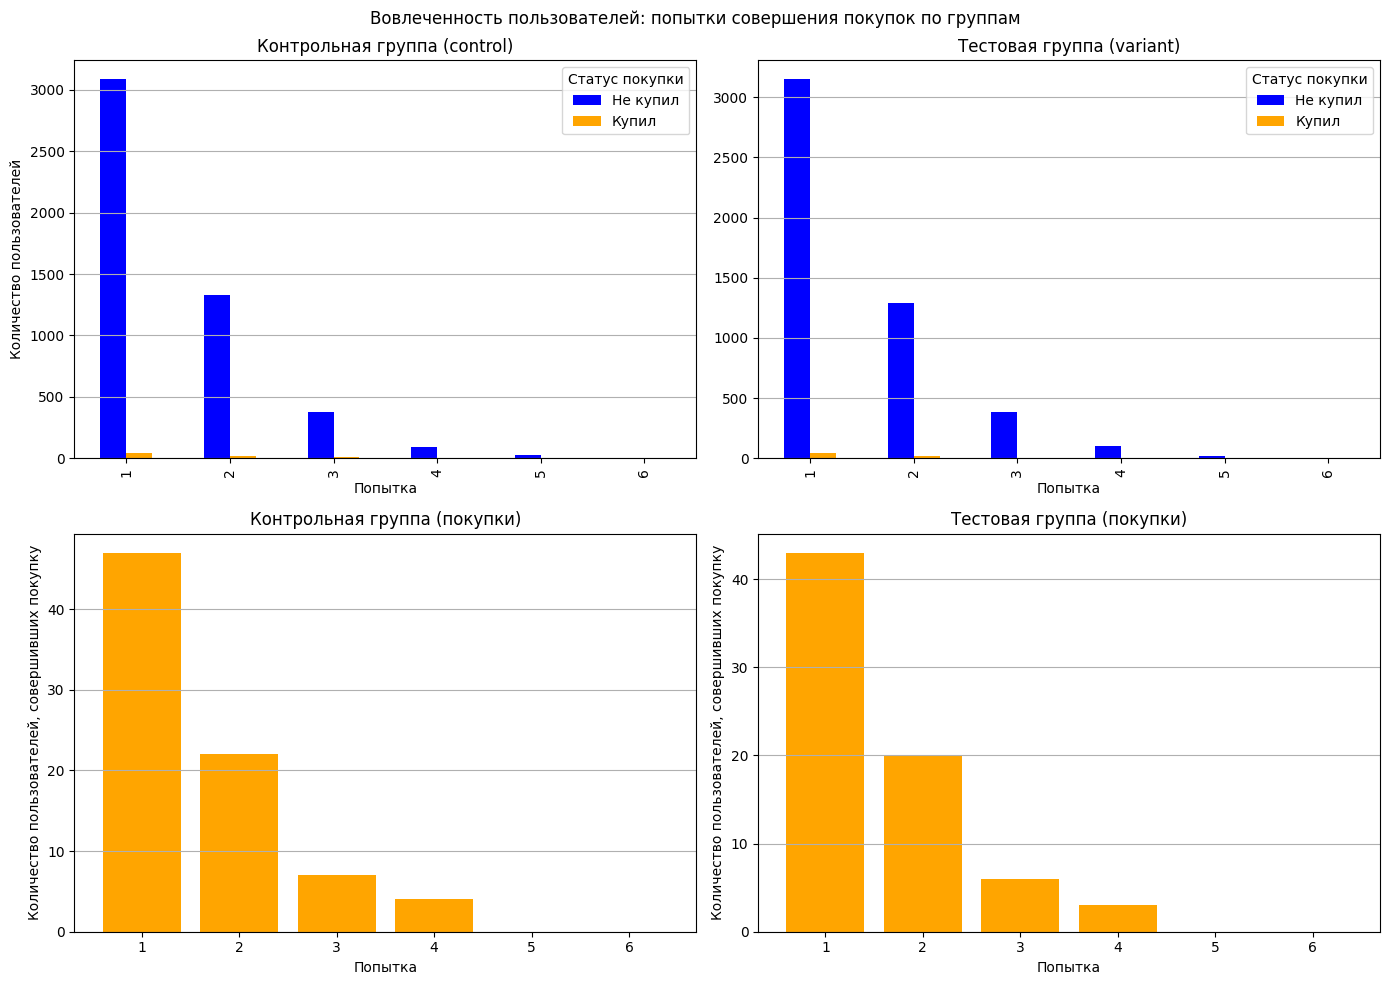

In [133]:
data['ATTEMPT'] = data.groupby('USER_ID').cumcount() + 1
data['PURCHASE'] = data['REVENUE'].apply(lambda x: 1 if x > 0 else 0)

# Считаем количество пользователей, сделавших покупку, по количеству попыток
engagement_summary = data.groupby(['VARIANT_NAME', 'ATTEMPT'])['PURCHASE'].value_counts().unstack(fill_value=0)

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=False) 

# График для контрольной группы
control_summary = engagement_summary.loc['control']
control_summary.plot(kind='bar', stacked=False, ax=axes[0, 0], color=['blue', 'orange'])
axes[0, 0].set_title('Контрольная группа (control)')
axes[0, 0].set_xlabel('Попытка')
axes[0, 0].set_ylabel('Количество пользователей')
axes[0, 0].legend(title='Статус покупки', labels=['Не купил', 'Купил'], loc='upper right')
axes[0, 0].grid(axis='y')

# График для тестовой группы
variant_summary = engagement_summary.loc['variant']
variant_summary.plot(kind='bar', stacked=False, ax=axes[0, 1], color=['blue', 'orange'])
axes[0, 1].set_title('Тестовая группа (variant)')
axes[0, 1].set_xlabel('Попытка')
axes[0, 1].legend(title='Статус покупки', labels=['Не купил', 'Купил'], loc='upper right')
axes[0, 1].grid(axis='y')

# Подграфик для контрольной группы (только купившие)
control_purchased = control_summary[1]  # Только купившие
axes[1, 0].bar(control_purchased.index, control_purchased.values, color='orange')
axes[1, 0].set_title('Контрольная группа (покупки)')
axes[1, 0].set_xlabel('Попытка')
axes[1, 0].set_ylabel('Количество пользователей, совершивших покупку')
axes[1, 0].grid(axis='y')

# Подграфик для тестовой группы (только купившие)
variant_purchased = variant_summary[1]  # Только купившие
axes[1, 1].bar(variant_purchased.index, variant_purchased.values, color='orange')
axes[1, 1].set_title('Тестовая группа (покупки)')
axes[1, 1].set_xlabel('Попытка')
axes[1, 1].set_ylabel('Количество пользователей, совершивших покупку')
axes[1, 1].grid(axis='y')

# Общий заголовок
plt.suptitle('Вовлеченность пользователей: попытки совершения покупок по группам')
plt.tight_layout()
plt.show()


Из графиков можно сделать вывод, что ничем не отличается версии сайта в уверености пользователей.

## 4. Итог

Результаты A/B тестирования показали следующие выводы:

- Отсутствие статистически значимого прироста в среднем доходе от пользователя.
- Отсутствие статистически значимого увеличения уверенности пользователей в процессе оформления покупки.
- Отсутствие статистически значимого роста конверсии между контрольной и тестовой группами.

Таким образом, альтернативная версия сайта не продемонстрировала значимых улучшений по сравнению с базовой версией для пользователей.